# Case 2. Diabetic Retinopathy Analysis
Mr.Sirichai Khomleart<br>
Mr.Puttiwat Wanna<br>
Last edited: 03.03.2019<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 0. Table of Contents
1. Objectives
2. Required Libraries
3. Data Description and Preprocessing
        3.1. Importing Datasets and Coverting to Binary Labels
        3.2. Setting Parameters
        3.3. Sampling Data
        3.4. Rescaling Image Data
        3.5. Splitting Image Data
        3.6. Image Data Augmentation
            3.6.1. Color-dataset Image Augmentation
            3.6.2. Gray-sclae dataset Image Augmentation
4. Modeling and Compilation
        4.1. Method 1; 4-layers Convolution Model with Color-image Dataset
        4.2. Method 2; 4-layers Convolution Model with Gray-scale Image Dataset
        4.3. Method 3; Xception Pre-trained Model with Color-image Dataset
        4.4. Method 4; VGG16 Pre-trained Model with Color-image Dataset
        4.5. Method 5; InceptionV3 Model Pre-trained Model with Color-image Dataset
        4.6. Method 6; InceptionResNetV2 Pre-trained Model with Color-image Dataset
5. Training and Validation
        5.1. Method 1; 4-layers Convolution Model with Color-image Dataset
        5.2. Method 2; 4-layers Convolution Model with Gray-scale Image Dataset
        5.3. Method 3; Xception Pre-trained Model with Color-image Dataset
        5.4. Method 4; VGG16 Pre-trained Model with Color-image Dataset
        5.5. Method 5; InceptionV3 Model Pre-trained Model with Color-image Dataset
        5.6. Method 6; InceptionResNetV2 Pre-trained Model with Color-image Dataset
6. Evaluation
        6.1. Scores for Final Model for Each Method
        6.2. Scores for Best Model for Each Method
        6.3. Test Scores for the Selected Method
7. Results and Discussion
8. Conclusions

## 1. Objectives

This case study aims for objectives as following
- Learn to use convolution neural networks to classify medical images
- Use keras’ neural networks to make an expert system to support a Diabetic Retinopathy analysis
- Learn to understand the basic nature of Convolution Neural Network and gain knowledge to adjust parameters to make the most accurate model
- Learn how to preprocess the image dataset which is completely different from the previous case study
- Learn to perform Image Augmentation like cropping and resizing images
- Learn to test model architectures (number of filters, filter size, activation functions) and training settings (epochs, batch sizes, validation splits) 
- Learn to make the documentation of the results clearly and in easily readable format
- Learn to perform methods to improve accuracy of model. For example, image augmentation, balancing dataset, drop out, etc
- Learn to use pretrained model from Keras applications like Xception, VGG16, InceptionV3, and InceptionResNetV2

## 2. Required Libraries

We begin our case study 2 by import all neccessary libraries below.

In [1]:
#Required libraries for this case study

#basic libraries
%pylab inline
import time
from time import localtime, strftime
import os
import cv2 #opencv
import pickle
import warnings
warnings.filterwarnings("ignore") #Disable warnings
import pandas as pd
import numpy as np
from numpy import corrcoef #Calculate correlation coefficient
from numpy import array
import matplotlib.pyplot as plt #Visual graphs
import pandas as pd

#sklearn libraries
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import normalize #normalize dataset
from sklearn.utils import shuffle #shuffle dataset
from sklearn.metrics import roc_curve #ROC Curves
from sklearn.metrics import auc #AUC 
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report #For Analysis
from sklearn.metrics import accuracy_score, roc_curve #For Calculation Scores

#keras libraries
import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras import models, layers
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.models import Model, load_model
from keras import optimizers
from keras.layers import Dense, Activation
from keras.preprocessing.image import ImageDataGenerator #For Image Augmentation
from keras.callbacks import ModelCheckpoint
from keras.applications import Xception #Pretrained Xception Model
from keras.applications import VGG16 #Pretrain VGG16 Model
from keras.applications import InceptionV3 #Pretrain InceptionV3 Model
from keras.applications import InceptionResNetV2 #Pretrain InceptionResNetV2

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## 3. Data Description and Preprocessing

Throughout this case study, we used the dataset from https://www.kaggle.com/sakarilukkarinen/preprocessed-diabetic-retinopathy-trainset provided by Sakari Lukkarinen, last updated on February 11, 2019 as our main source of data.

This dataset is the minimal pre-processed version of the dataset using in <b>Diabetic Retinopathy Detection</b> Kaggle competition held in 2015 offered excellent dataset for testing and training deep neural network classifiers for health care applications. It contains several dozens of thousands healthy and diseased fundus photography images.

The original dataset contained over 34000 training images and consumed space around 82 GB, so the pre-processed dataset we used is the minimal version that immitated image preprocessing techniques used by the winner of competition.

Here is <b>how data was preprocessed</b> by OpenCV in the new dataset.
- <b>Rescaled the image</b> to have the same rasius (300pixels or 500 pixels)
- <b>Subtracted the local average color</b>; the local average get mapped to 50% gray
- <b>Clipped the image</b> to 90% size to remove the boundary effectd

The preprocessed dataset estimately consumed space around 11 GB and has 4 files inside.
1. <b>newTrainLabels.csv</b> is the label file of train images dataset. There are 3 columns describing the train data.
    - <b>image</b> = name of the image file (without the extension *.jpeg)
    - <b>level</b> = level of the retinopathy <i>(0 = healthy/no diabetic retinopathy, 1 = mild case, 2 = moderate case, 3 = severe case, 4 = proliferative diabetic retinopathy case)</i>
    - <b>MB</b> = size of the image file in MegaBytes
    - We will use the image column as a feature of model and the level column as a label to be predicted, and ignore the MB column.
2. <b>retinopathy_solution.csv</b> is the label file of test images dataset. There are 3 columns describing the test data.
    - <b>image</b> = name of the image file (without the extension *.jpeg)
    - <b>level</b> = level of the retinopathy <i>(0 = healthy/no diabetic retinopathy, 1 = mild case, 2 = moderate case, 3 = severe case, 4 = proliferative diabetic retinopathy case)</i>
    - <b>Usage</b> = Usage in original competition (public = for public rankings, private = for private rankings)
    - We will use the image column as a feature of model and the level column as a label to be predicted, and ignore the Usage column.
3. <b>300_train.zip</b> is the preprocessed version of Diabetic Retinopathy Detection 2015 competition train data.
4. <b>300_test.zip</b> is the preprocessed version of Diabetic Retinopathy Detection 2015 competition test data.

Note that:
- This case study will predict the diabetic retinopathy in binary prediction <i>(0 = no diabetic retinopathy detected, 1 = diabetic retinopathy detected)</i>

### 3.1. Importing Datasets and Coverting to Binary Labels
<hr>

In [2]:
#Read the train image names and labels
df = pd.read_csv('./input/newTrainLabels.csv')
#Read the test image names and labels
df_solution = pd.read_csv('./input/retinopathy_solution.csv')

In [3]:
#Check the train dataframe
df.head()

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906


In [4]:
#Check the test dataframe
df_solution.head()

,image,level,Usage
0,1_left,0,Private
1,1_right,0,Private
2,2_left,0,Public
3,2_right,0,Public
4,3_left,2,Private


As we stated earlier, we will predict the diabetic retinopathy in binary prediction, so we change all of the level that is above 0 to 1. Means that now 0 is no diabetic retinopathy detected label and 1 is diabetic retinopathy detected label.

In [5]:
# Convert categorical level into binary for training dataset 
df['level'] = 1*(df['level'] > 0)
# Convert categorical level into binary for testing dataset 
df_solution['level'] = 1*(df_solution['level'] > 0)

In [6]:
#Cheack how many records per label in training dataset
df['level'].value_counts()

0    25808
1     9316
Name: level, dtype: int64

In [7]:
#Cheack how many records per label in testing dataset
df_solution['level'].value_counts()

0    39533
1    14043
Name: level, dtype: int64

### 3.2. Setting Parameters
<hr>

You can see that we already have train dataset and test dataset, but we lack the validation dataset. So, I will seperate training dataset into training dataset and validation set. The normal practice for spliting data is <b>50:25:25</b> for <b>training:validation:testing</b> data. Since we have 35142 records for training dataset and 53576 records for testing dataset, We will use 7500 records from training dataset for the new training data, 3750 records from training dataset for the new validation set, and 3750 records from testing set for new testing data. 

There is a reason for why I chose that number of record to be used, that is to have the same number of the label 0 and 1 for training data and validation data.

I think that, to <b>reduce unnessary bias</b>, we should make the training and validation data contain the same number in each label we want to predict. We can see that the minimum number of records in both training and testing data is the number of label 1 from training data, which is 9316 records. So, if we want to have the ratio between training and validation data be 50 and 25, these records have to be seperated into 3750 records and 1875 records respectively (actually it can be increased to 6210 and 3105 records respectively, but due to our computer performance limitation, we set it smaller). Then, we select the number of records for testing data equal to number of validation data records.

In conclusion, we will have
- <b>Training data</b> (7500 records)
    - <i>Label 0</i>: 3750 records
    - <i>Label 1</i>: 3750 records
- <b>Validation data</b> (3750 records)
    - <i>Label 0</i>: 1875 records
    - <i>Label 1</i>: 1875 records
- <b>Testing data</b> (3750 records)
    - <i>Label 0</i>: 1875 records
    - <i>Label 1</i>: 1875 records
    
Next, we also set global parameters like batch size, image size, and number of epochs for using with all models we will try.
<br>We set the batch size to 16, the number of epochs to 50, and the image size to 150*150 due to our computer performance limitation

In [8]:
#### Declare Parameters for Setting Models
TRAIN_SIZE = 11250 # Total number of images pooled from 300_train
TEST_SIZE = 3750 # Total number of image pooled from 300_test for testing set
SPLIT = 7500 # Number of images used for training
# TRAIN_SIZE = 18630 # Total number of images pooled from 300_train
# TEST_SIZE = 6210 # Total number of image pooled from 300_test for testing set
# SPLIT = 12420 # Number of images used for training
BATCH_SIZE = 16
TRAIN_STEPS = SPLIT // BATCH_SIZE
VALID_STEPS = (TRAIN_SIZE - SPLIT) // BATCH_SIZE
EPOCHS = 50
N_EPOCHS = 0
IMAGE_SIZE = 150

#Print Total Number of Dataset
print('-----Dataset-----')
print('Training records:    ', SPLIT)
print('Validation records:  ', TRAIN_SIZE - SPLIT)
print('Test records:        ', TEST_SIZE)

#Print All Information
print('-----Settings-----')
print('Batch size:      ', BATCH_SIZE)
print('Training steps:  ', TRAIN_STEPS)
print('Validation steps:', VALID_STEPS)
print('Epochs:          ', EPOCHS)
print('Image size:      ', (IMAGE_SIZE, IMAGE_SIZE, 3))

-----Dataset-----
Training records:     7500
Validation records:   3750
Test records:         3750
-----Settings-----
Batch size:       16
Training steps:   468
Validation steps: 234
Epochs:           50
Image size:       (150, 150, 3)


### 3.3. Sampling Data
<hr>
Now we sample data from 300_train and 300_test floders as we set parameters above.

In [9]:
#Create temperary destination directory
dest_dir = './temp/'

try:
    os.mkdir(dest_dir)
    print('Created a directory:', dest_dir)
except:
    # Temp directory already exist, so clear it
    for file in os.listdir(dest_dir):  
        file_path = os.path.join(dest_dir, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
    print(dest_dir, ' cleared.')

./temp/  cleared.


In [9]:
#Then sample data from large dataset as we describe above
#Sample training and validation data fromlarge training dataset
df = df.groupby('level').apply(lambda x: x.sample(TRAIN_SIZE//2, random_state = 1).reset_index(drop=True))
#Sample testing data from large testing dataset
df_solution = df_solution.groupby('level').apply(lambda x: x.sample(TEST_SIZE//2, random_state = 1).reset_index(drop=True))

#Print to see number of records
print('Number of records per label for training and validation dataset')
print(df['level'].value_counts(),'\n')
print('Number of records per label for testing dataset')
print(df_solution['level'].value_counts())

Number of records per label for training and validation dataset
1    5625
0    5625
Name: level, dtype: int64 

Number of records per label for testing dataset
1    1875
0    1875
Name: level, dtype: int64


### 3.4. Rescaling Image Data
<hr>
Now we rescale images we use for training and testing to the same size mentioned above (150*150).

In [10]:
# Source directory
source_dir = './input/300_train/'

# Create destination directory
dest_dir = './temp/'

In [11]:
try:
    os.mkdir(dest_dir)
    print('Created a directory:', dest_dir)
except:
    print(dest_dir, 'already exists!')

# Start timing
start = time.time()

# Crop and resize all images. Store them to dest_dir
print('Cropping and rescaling the images:')
for i, file in enumerate(df['image']):
    try:
        fname = source_dir + file + '.jpeg'
        img = cv2.imread(fname)
    
        # Crop the image to the height
        h, w, c = img.shape
        if w > h:
            wc = int(w/2)
            w0 = wc - int(h/2)
            w1 = w0 + h
            img = img[:, w0:w1, :]
        # Rescale to N x N
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        # Save
        new_fname = dest_dir + file + '.png'
        cv2.imwrite(new_fname, img)
    except:
        # Display the image name having troubles
        print(fname)
         
    # Print the progress for every N images
    if (i % 5000 == 0) & (i > 0):
        print('{:} images resized in {:.2f} seconds.'.format(i, time.time()-start))

# End timing
print('Total elapsed time {:.2f} seconds.'.format(time.time()-start))

./temp/ already exists!
Cropping and rescaling the images:
5000 images resized in 87.63 seconds.
10000 images resized in 163.22 seconds.
Total elapsed time 182.21 seconds.


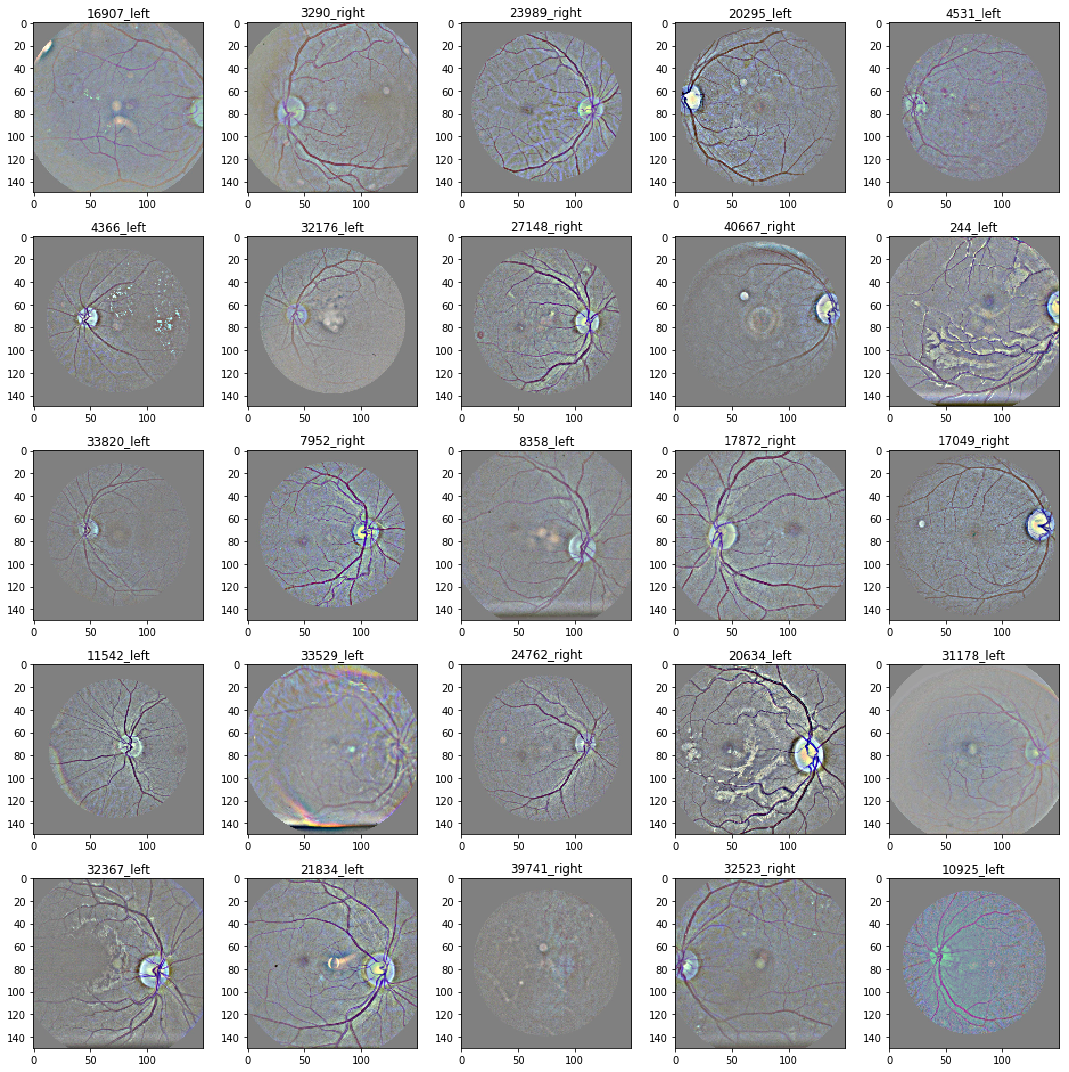

In [11]:
# Now we check the processed images
# Show rows x cols of randomly selected images
rows = 5
cols = 5
f, ax = plt.subplots(rows, cols, figsize = (rows*3, cols*3), squeeze = True)
L = TRAIN_SIZE
for i in range(rows*cols):
    n = np.random.randint(L) # Pool from all processed images
    file = df['image'].iloc[n]
    fname = dest_dir + file + '.png'
    img = cv2.imread(fname)
    a = ax.flat[i]
    a.imshow(img)
    a.set_title(file)
plt.tight_layout()
plt.show()

### 3.5. Splitting Image Data
<hr>
Now we split images from large training set into training set and validation set.

In [12]:
#Define parameters for features and labels
X = df.image
y = df.level

#Equally split dataset into traning set and validation set for all labels
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.33333, random_state=42)
for train_dat,test_dat in stratSplit.split(X, y):
    X_train = X[train_dat]
    y_train = y[train_dat]
    X_val = X[test_dat]
    y_val = y[test_dat]
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

#Print to see number of records
print('Number of records per label for training dataset')
print(df_train['level'].value_counts(),'\n')
print('Number of records per label for validation dataset')
print(df_val['level'].value_counts(),'\n')
print('Number of records per label for testing dataset')
print(df_solution['level'].value_counts())

Number of records per label for training dataset
1    3750
0    3750
Name: level, dtype: int64 

Number of records per label for validation dataset
1    1875
0    1875
Name: level, dtype: int64 

Number of records per label for testing dataset
1    1875
0    1875
Name: level, dtype: int64


### 3.6. Image Data Augmentation
<hr>
Throughout this experiment, we will try different methods and compare the results to find the best and most accurate model for analyzing diabetic retinopathy. The experiments include the comparison between using convolution model with color-image dataset and gray-scale image dataset, as well as other pre-trained models.

So, we need to preprocess our data into two groups, color-images dataset and gray-scale images dataset.

The reasons we need gray-scale dataset is because we assume that gray-scale image will perform better due to the unnecessary color data was remove,<b>we believed that color information isn't important for diabetic retinopathy analysis</b>.

For both color and grayscale training dataset, we will perform augmentation as following
- Rescale image value from 0-255 tp 0-1 (normalization)
- Allow zoom range at 0.1
- Prohibit featurewise center
- Prohibit samplewise center
- Prohibit featurewise standard normalization
- Prohibit samplewise standard normalization
- Prohibit whitening
- Allow rotation range at 360 degrees,
- Allow width shift range at 0.2
- Allow height shift range at 0.2
- Allow horizontal flip
- Allow vertical flip

#### 3.6.1. Color-dataset Image augmentation

In [13]:
print('---For color dataset---')

#Set augmentation parameters
#Train generator: rescale, zoom, rotate and flip
train_generator = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.1,
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=60,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
)

#Validation generator, only rescale the images from 0..255 to range 0..1
valid_generator = ImageDataGenerator(rescale = 1./255)

#Test generator, only rescale the images from 0..255 to range 0..1
test_generator = ImageDataGenerator(rescale = 1./255)

#Perform augmentation
#Training flow
print('Training flow:')
train_flow = train_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = dest_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = True
)

# Validation flow (balance)
print('Validation flow:')
valid_flow = valid_generator.flow_from_dataframe(
    dataframe = df_val,
    directory = dest_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

# Test flow
print('Test flow:')
test_flow = test_generator.flow_from_dataframe(
    dataframe = df_solution,
    directory = './input/300_test/',
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

---For color dataset---
Training flow:
Found 7500 images belonging to 2 classes.
Validation flow:
Found 3750 images belonging to 2 classes.
Test flow:
Found 3750 images belonging to 2 classes.


#### 3.6.2. Gray-sclae dataset Image augmentation

In [14]:
print('---For grayscale dataset---')

#Set augmentation parameters
#Train generator: rescale, zoom, rotate and flip
train_generator = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.1,
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=60,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

#Validation generator, only rescale the images from 0..255 to range 0..1
valid_generator = ImageDataGenerator(rescale = 1./255)

#Test generator, only rescale the images from 0..255 to range 0..1
test_generator = ImageDataGenerator(rescale = 1./255)

#Perform augmentation
#Training flow
print('Training flow:')
train_flow_gray = train_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = dest_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    color_mode = 'grayscale'
)

# Validation flow (balance)
print('Validation flow:')
valid_flow_gray = valid_generator.flow_from_dataframe(
    dataframe = df_val,
    directory = dest_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False, 
    color_mode = 'grayscale'
)

# Test flow
print('Test flow:')
test_flow_gray = test_generator.flow_from_dataframe(
    dataframe = df_solution,
    directory = './input/300_test/',
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False, 
    color_mode = 'grayscale'
)

---For grayscale dataset---
Training flow:
Found 7500 images belonging to 2 classes.
Validation flow:
Found 3750 images belonging to 2 classes.
Test flow:
Found 3750 images belonging to 2 classes.


## 4. Modeling and Compilation

As we stated earlier, we will try different methods and compare the results to find the best and most accurate model for analyzing diabetic retinopathy. Our models in this experiment include...

1. <b>4-layers Convolution Model</b> with Color-image Dataset
2. <b>4-layers Convolution Model</b> with Gray-scale Image Dataset
3. <b>Xception Pre-trained Model</b> with Color-image Dataset
4. <b>VGG16 Pre-trained Model</b> with Color-image Dataset
5. <b>InceptionV3 Model Pre-trained Model</b> with Color-image Dataset
6. <b>InceptionResNetV2 Pre-trained Model</b> with Color-image Dataset

### 4.1. Method 1; 4-layers Convolution Model with Color-image Dataset
First, we start with a basic convolution model we learned in the class to find the base loss and accuracy. Here is our model architecture.

In [16]:
#4-layers Convolution Model with Color-image Dataset
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))) #accept input to be RGB
model1.add(Conv2D(32, (3, 3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), activation = 'relu'))
model1.add(Conv2D(64, (3, 3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = 'relu'))
# model1.add(Dropout(0.5))
model1.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer = sgd,
             loss='binary_crossentropy', 
              metrics = ["accuracy"])

#model1.summary()

### 4.2. Method 2; 4-layers Convolution Model with Gray-scale image Dataset
Alternatively, we try the same model with gray-scale dataset with the hope that the accuracy or performance will improve, we believed that color information isn't nescessary for diabetic retinopathy analysis. Here is model architecture.

In [15]:
#4-layers Convolution Model with Gray-scale image Dataset
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1))) #change input to grayscale
model2.add(Conv2D(32, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
# model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))
# model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(256, activation = 'relu'))
# model2.add(Dropout(0.5))
model2.add(Dense(1, activation = 'sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer = sgd,
             loss='binary_crossentropy', 
              metrics = ["accuracy"])

#model2.summary()

### 4.3. Method 3; Xception Pre-trained Model with Color-image Dataset
Next, we try using Xception Pre-trained Model with our color-image data after we found out that performing on gray-scale dataset improved neither accuracy nor performance.

The Xception architecture is a linear stack of depthwise separable convolution layers with residual connections. “Xception” means “Extreme Inception”, as this new model uses depthwise separable convolutions, which are at one extreme of the spectrum.

In [34]:
# Create the pretraining Xception model, pop out the last dense layer
base_model3 = Xception(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x = Dense(1)(base_model3.get_layer('avg_pool').output)
y = Activation('sigmoid')(x)
model3 = Model(inputs = base_model3.input, outputs = y)

# Optimizer, loss and metrics
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model3.summary()

### 4.4. Method 4; VGG16 Pre-trained Model with Color-image Dataset
Then we use VGG16 Pre-trained Model with our color-image data

VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to win the ILSVR (ImageNet) Competition in 2014. To this day, it is still considered to be an excellent vision model, although it has been somewhat outperformed by more recent advances such as Inception and ResNet.

In [20]:
# Create the pretraining VGG16 model, pop out the last dense layer
base_model4 = VGG16(weights='imagenet', include_top=False)
x = base_model4.get_layer('block5_conv3').output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model4 = Model(inputs=base_model4.input, outputs=x)

# Optimizer, loss and metrics
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model4.summary()

### 4.5. Method 5; InceptionV3 Model Pre-trained Model with Color-image Dataset
After that, we try InceptionV3 Pre-trained Model with our color-image data

Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model is the culmination of many ideas developed by multiple researchers over the years. It is based on the original paper: "Rethinking the Inception Architecture for Computer Vision" by Szegedy, et. al.

In [16]:
# Create the pretraining InceptionV2 model, pop out the last dense layer
base_model5 = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x = Dense(1)(base_model5.get_layer('avg_pool').output)
y = Activation('sigmoid')(x)
model5 = Model(inputs = base_model5.input, outputs = y)

# Optimizer, loss and metrics
model5.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model5.summary()

### 4.6. Method 6; InceptionResNetV2 Pre-trained Model with Color-image Dataset
Lastly, we use InceptionResNetV2 Pre-trained Model with our color-image data.

Inception-ResNet-v2 is a variation of our earlier Inception V3 model which borrows some ideas from Microsoft's ResNet papers.

In [16]:
# Create the pretraining InceptionResNetV2 model, pop out the last dense layer
base_model6 = InceptionResNetV2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x = Dense(1)(base_model6.get_layer('avg_pool').output)
y = Activation('sigmoid')(x)
model6 = Model(inputs = base_model6.input, outputs = y)

# Optimizer, loss and metrics
model6.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model6.summary()

## 5. Training and Validation

In this section, we will train each model and find out the score for the final model and the best model for each method.

We train each model with training flow we have prepared and validate them with our validation flow. For each method, we will set call back to save the best model (decided by looking at the validation loss) to files for later use.

For the final model in each method, we save to the file name 'model1.h5', 'model2.h5', 'model3.h5', 'model4.h5', 'model5.h5', and 'model6.h5'

For the best model in each method, we save to thr file name 'best_model1.h5', 'best_model2.h5', 'best_model3.h5', 'best_model4.h5', 'best_model5.h5', and 'best_model6.h5'

Here is our code for training each model and plotting graphical representation comparing between accuracy with epoch and loss with epoch.

### 5.1. Method 1; 4-layers Convolution Model with Color-image Dataset

In [17]:
# Save the model giving best validation loss
cb1 = ModelCheckpoint('best_model1.h5', 
                      monitor = 'val_loss', 
                      verbose = 0, 
                      save_best_only = True)

# Start timing
start = time.time()

# Training
print('Training the model ...')
history1 = model1.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = [cb1],
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Update the initial epoch, used for saving the previous trainings, if trained several times
N_EPOCHS = N_EPOCHS + EPOCHS
model1.save('model1.h5')

# Save the history
import pickle
with open('trainHistory_model1', 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

Training the model ...
Epoch 1/50
468/468 [==============================] - 79s 170ms/step - loss: 0.6939 - acc: 0.4968 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 2/50
468/468 [==============================] - 58s 125ms/step - loss: 0.6935 - acc: 0.5040 - val_loss: 0.6932 - val_acc: 0.5008
Epoch 3/50
468/468 [==============================] - 57s 122ms/step - loss: 0.6935 - acc: 0.4981 - val_loss: 0.6936 - val_acc: 0.5005
Epoch 4/50
468/468 [==============================] - 57s 122ms/step - loss: 0.6936 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 5/50
468/468 [==============================] - 57s 122ms/step - loss: 0.6935 - acc: 0.5045 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 6/50
468/468 [==============================] - 57s 122ms/step - loss: 0.6937 - acc: 0.5035 - val_loss: 0.6931 - val_acc: 0.5112
Epoch 7/50
468/468 [==============================] - 57s 122ms/step - loss: 0.6938 - acc: 0.4946 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 8/50
468/468 [============

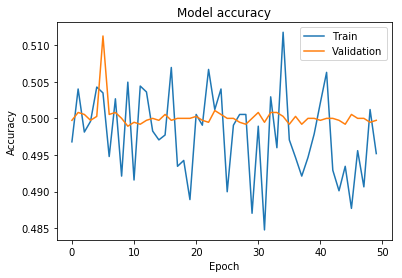

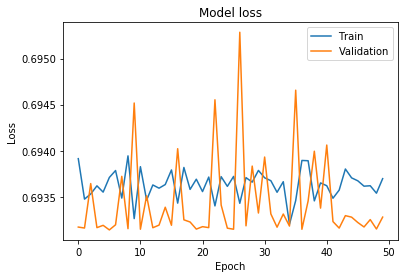

In [18]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### 5.2. Method 2; 4-layers Convolution Model with Gray-scale Image Dataset

In [16]:
# Save the model giving best validation loss
cb2 = ModelCheckpoint('best_model2.h5', 
                      monitor = 'val_loss', 
                      verbose = 0, 
                      save_best_only = True)

# Start timing
start = time.time()

# Training
print('Training the model ...')
history2 = model2.fit_generator(
    generator = train_flow_gray,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = [cb2],
    validation_data = valid_flow_gray,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Update the initial epoch, used for saving the previous trainings, if trained several times
N_EPOCHS = N_EPOCHS + EPOCHS
model2.save('model2.h5')

# Save the history
import pickle
with open('trainHistory_model2', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

Training the model ...
Epoch 1/50
468/468 [==============================] - 68s 145ms/step - loss: 0.6937 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 2/50
468/468 [==============================] - 57s 121ms/step - loss: 0.6934 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.4992
Epoch 3/50
468/468 [==============================] - 56s 119ms/step - loss: 0.6939 - acc: 0.4934 - val_loss: 0.6934 - val_acc: 0.4995
Epoch 4/50
468/468 [==============================] - 56s 119ms/step - loss: 0.6937 - acc: 0.5028 - val_loss: 0.6934 - val_acc: 0.4997
Epoch 5/50
468/468 [==============================] - 56s 119ms/step - loss: 0.6936 - acc: 0.4924 - val_loss: 0.6936 - val_acc: 0.4997
Epoch 6/50
468/468 [==============================] - 56s 119ms/step - loss: 0.6935 - acc: 0.4921 - val_loss: 0.6937 - val_acc: 0.4992
Epoch 7/50
468/468 [==============================] - 56s 119ms/step - loss: 0.6934 - acc: 0.5041 - val_loss: 0.6933 - val_acc: 0.5005
Epoch 8/50
468/468 [============

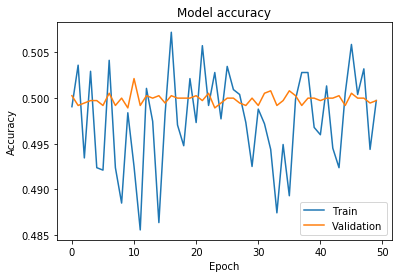

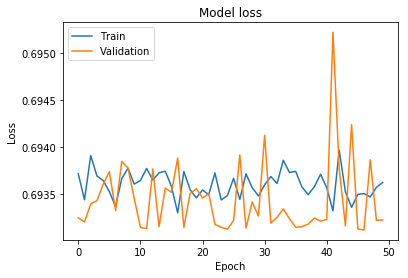

In [17]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### 5.3. Method 3; Xception Pre-trained Model with Color-image Dataset

In [37]:
# Save the model giving best validation loss
cb3 = ModelCheckpoint('best_model3.h5', 
                      monitor = 'val_loss', 
                      verbose = 0, 
                      save_best_only = True)

# Start timing
start = time.time()

# Training
print('Training the model ...')
history3 = model3.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = [cb3],
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Update the initial epoch, used for saving the previous trainings, if trained several times
N_EPOCHS = N_EPOCHS + EPOCHS
model3.save('model3.h5')

# Save the history
import pickle
with open('trainHistory_model3', 'wb') as file_pi:
    pickle.dump(history3.history, file_pi)

Training the model ...
Epoch 1/50
468/468 [==============================] - 342s 730ms/step - loss: 0.6891 - acc: 0.5418 - val_loss: 1.2864 - val_acc: 0.5000
Epoch 2/50
468/468 [==============================] - 343s 732ms/step - loss: 0.6603 - acc: 0.5962 - val_loss: 0.7517 - val_acc: 0.5281
Epoch 3/50
468/468 [==============================] - 344s 736ms/step - loss: 0.6324 - acc: 0.6443 - val_loss: 0.6939 - val_acc: 0.5710
Epoch 4/50
468/468 [==============================] - 342s 731ms/step - loss: 0.6200 - acc: 0.6640 - val_loss: 0.6384 - val_acc: 0.6604
Epoch 5/50
468/468 [==============================] - 342s 731ms/step - loss: 0.6211 - acc: 0.6579 - val_loss: 0.7007 - val_acc: 0.6205
Epoch 6/50
468/468 [==============================] - 342s 731ms/step - loss: 0.6104 - acc: 0.6729 - val_loss: 0.6064 - val_acc: 0.6691
Epoch 7/50
468/468 [==============================] - 342s 731ms/step - loss: 0.6084 - acc: 0.6745 - val_loss: 0.8636 - val_acc: 0.5787
Epoch 8/50
468/468 [=====

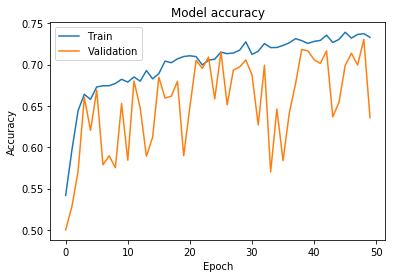

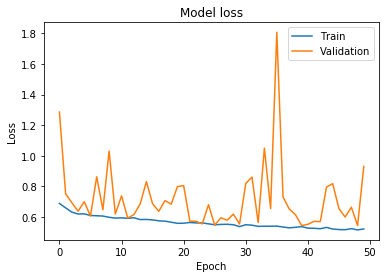

In [38]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### 5.4. Method 4; VGG16 Pre-trained Model with Color-image Dataset

In [21]:
# Save the model giving best validation loss
cb4 = ModelCheckpoint('best_model4.h5', 
                      monitor = 'val_loss', 
                      verbose = 0, 
                      save_best_only = True)

# Start timing
start = time.time()

# Training
print('Training the model ...')
history4 = model4.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = [cb4],
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Update the initial epoch, used for saving the previous trainings, if trained several times
N_EPOCHS = N_EPOCHS + EPOCHS
model4.save('model4.h5')

# Save the history
import pickle
with open('trainHistory_model4', 'wb') as file_pi:
    pickle.dump(history4.history, file_pi)

Training the model ...
Epoch 1/50
468/468 [==============================] - 252s 538ms/step - loss: 8.0242 - acc: 0.5005 - val_loss: 8.0547 - val_acc: 0.5003
Epoch 2/50
468/468 [==============================] - 247s 528ms/step - loss: 8.0532 - acc: 0.5004 - val_loss: 8.0461 - val_acc: 0.5008
Epoch 3/50
468/468 [==============================] - 242s 518ms/step - loss: 8.0583 - acc: 0.5000 - val_loss: 8.0504 - val_acc: 0.5005
Epoch 4/50
468/468 [==============================] - 242s 518ms/step - loss: 8.0626 - acc: 0.4998 - val_loss: 8.0634 - val_acc: 0.4997
Epoch 5/50
468/468 [==============================] - 242s 518ms/step - loss: 8.0798 - acc: 0.4987 - val_loss: 8.0547 - val_acc: 0.5003
Epoch 6/50
468/468 [==============================] - 242s 518ms/step - loss: 8.0425 - acc: 0.5010 - val_loss: 8.0461 - val_acc: 0.5008
Epoch 7/50
468/468 [==============================] - 242s 518ms/step - loss: 8.0719 - acc: 0.4992 - val_loss: 8.0504 - val_acc: 0.5005
Epoch 8/50
468/468 [=====

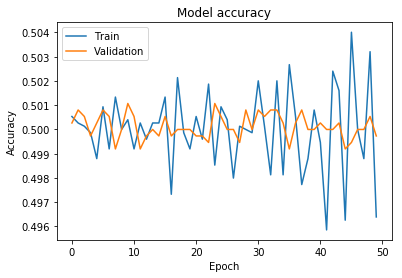

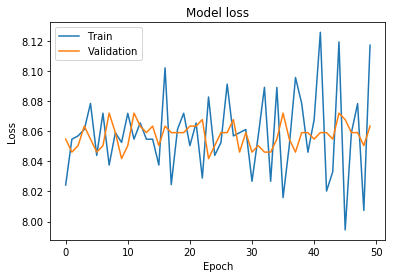

In [22]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### 5.5. Method 5; InceptionV3 Model Pre-trained Model with Color-image Dataset

In [18]:
# Save the model giving best validation loss
cb5 = ModelCheckpoint('best_model5.h5', 
                      monitor = 'val_loss', 
                      verbose = 0, 
                      save_best_only = True)

# Start timing
start = time.time()

# Training
print('Training the model ...')
history5 = model5.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = [cb5],
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Update the initial epoch, used for saving the previous trainings, if trained several times
N_EPOCHS = N_EPOCHS + EPOCHS
model5.save('model5.h5')

# Save the history
import pickle
with open('trainHistory_model5', 'wb') as file_pi:
    pickle.dump(history5.history, file_pi)

Training the model ...
Epoch 1/50
468/468 [==============================] - 184s 394ms/step - loss: 0.7409 - acc: 0.4916 - val_loss: 2.0497 - val_acc: 0.4997
Epoch 2/50
468/468 [==============================] - 167s 358ms/step - loss: 0.7102 - acc: 0.5024 - val_loss: 2.6760 - val_acc: 0.5083
Epoch 3/50
468/468 [==============================] - 167s 357ms/step - loss: 0.7066 - acc: 0.5066 - val_loss: 0.6943 - val_acc: 0.5024
Epoch 4/50
468/468 [==============================] - 168s 359ms/step - loss: 0.7065 - acc: 0.4983 - val_loss: 0.7133 - val_acc: 0.5016
Epoch 5/50
468/468 [==============================] - 167s 357ms/step - loss: 0.7061 - acc: 0.4917 - val_loss: 1.0401 - val_acc: 0.5043
Epoch 6/50
468/468 [==============================] - 168s 358ms/step - loss: 0.7067 - acc: 0.4932 - val_loss: 0.7212 - val_acc: 0.5003
Epoch 7/50
468/468 [==============================] - 167s 358ms/step - loss: 0.7022 - acc: 0.5055 - val_loss: 0.7047 - val_acc: 0.5062
Epoch 8/50
468/468 [=====

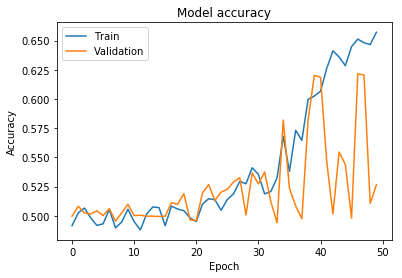

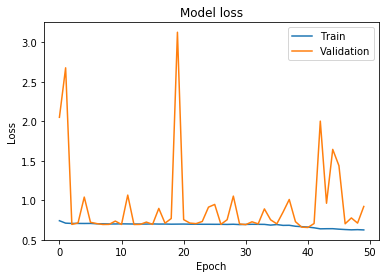

In [19]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### 5.6. Method 6; InceptionResNetV2 Pre-trained Model with Color-image Dataset

In [18]:
# Save the model giving best validation loss
cb6 = ModelCheckpoint('best_model6.h5', 
                      monitor = 'val_loss', 
                      verbose = 0, 
                      save_best_only = True)

# Start timing
start = time.time()

# Training
print('Training the model ...')
history6 = model6.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = [cb6],
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Update the initial epoch, used for saving the previous trainings, if trained several times
N_EPOCHS = N_EPOCHS + EPOCHS
model6.save('model6.h5')

# Save the history
import pickle
with open('trainHistory_model6', 'wb') as file_pi:
    pickle.dump(history6.history, file_pi)

Training the model ...
Epoch 1/50
468/468 [==============================] - 415s 887ms/step - loss: 0.7136 - acc: 0.5755 - val_loss: 2.6307 - val_acc: 0.5227
Epoch 2/50
468/468 [==============================] - 380s 811ms/step - loss: 0.6501 - acc: 0.6296 - val_loss: 0.6799 - val_acc: 0.5943
Epoch 3/50
468/468 [==============================] - 376s 804ms/step - loss: 0.6343 - acc: 0.6440 - val_loss: 0.7597 - val_acc: 0.5860
Epoch 4/50
468/468 [==============================] - 377s 805ms/step - loss: 0.6289 - acc: 0.6558 - val_loss: 0.6221 - val_acc: 0.6564
Epoch 5/50
468/468 [==============================] - 376s 804ms/step - loss: 0.6240 - acc: 0.6534 - val_loss: 0.6283 - val_acc: 0.6318
Epoch 6/50
468/468 [==============================] - 376s 804ms/step - loss: 0.6226 - acc: 0.6546 - val_loss: 0.6466 - val_acc: 0.6312
Epoch 7/50
468/468 [==============================] - 376s 804ms/step - loss: 0.6213 - acc: 0.6617 - val_loss: 0.7381 - val_acc: 0.5809
Epoch 8/50
468/468 [=====

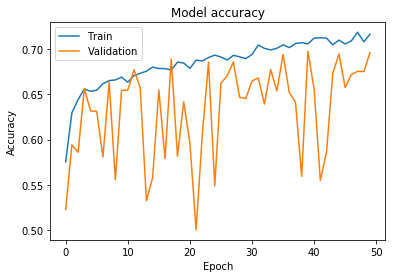

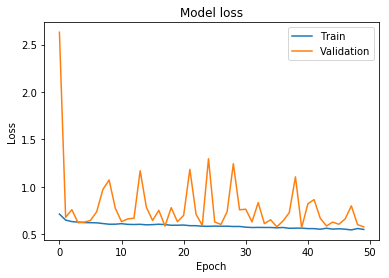

In [19]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

## 6. Evaluation
After we have trained all models in each method, we now calculate the matrix score, like a confusion matrix, to find which model is the best. 

For matrix scores, we use following scores to determine the best model
- Confusion matrix
- Model accuracy
- Precision
- Recall
- F1-score
- Support

Here is a predefined function for the output of those scores.

In [31]:
# Function to display confusion matrix, classification report and final accuracy
def display_results(m, flow):
    # Get the true and predicted values
    y_true = flow.classes
    predict = m.predict_generator(flow, steps=len(flow), verbose=1)
    y_pred = 1*(predict > 0.5)
    
    # ROC Curve
    print('ROC curve:')
    fpr, tpr, thresholds = roc_curve(y_true, predict)
    plt.plot(fpr, tpr, color='darkorange', lw = 2)
    plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.show()

    # Calculate and print the metrics results
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        cm = confusion_matrix(y_true, y_pred)
        print('Confusion matrix:')
        print(cm)
        print('')

        a = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.4f}'.format(a))
        print('')

        cr = classification_report(y_true, y_pred)
        print('Classification report:')
        print(cr)

### 6.1. Scores for Final Model for Each Method
Then we load each final model we saved and apply display_result function.

The result of each model will be discussed again in the Results and Discussion section.

Loading final model from file model1.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for model1.h5
235/235 [==============================] - 8s 32ms/step
ROC curve:


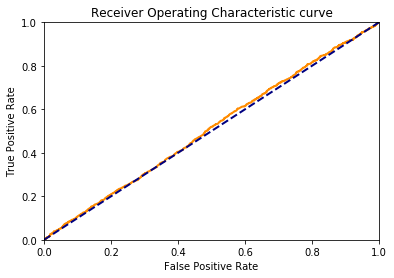

Confusion matrix:
[[1875    0]
 [1875    0]]

Accuracy: 0.5000

Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1875
           1       0.00      0.00      0.00      1875

   micro avg       0.50      0.50      0.50      3750
   macro avg       0.25      0.50      0.33      3750
weighted avg       0.25      0.50      0.33      3750

None
------------------------------------------------------------------------
Loading final model from file model2.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for model2.h5
235/235 [==============================] - 7s 29ms/step
ROC curve:


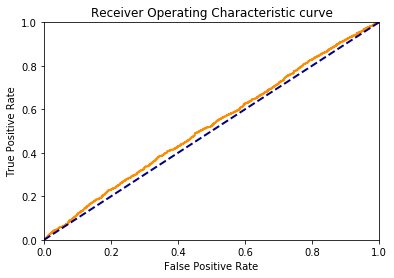

Confusion matrix:
[[1875    0]
 [1875    0]]

Accuracy: 0.5000

Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1875
           1       0.00      0.00      0.00      1875

   micro avg       0.50      0.50      0.50      3750
   macro avg       0.25      0.50      0.33      3750
weighted avg       0.25      0.50      0.33      3750

None
------------------------------------------------------------------------
Loading final model from file model3.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for model3.h5
235/235 [==============================] - 32s 137ms/step
ROC curve:


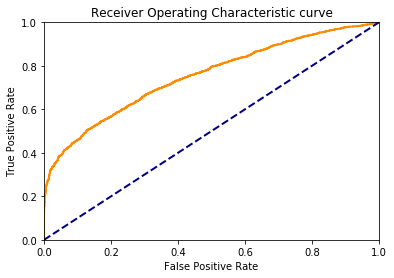

Confusion matrix:
[[1848   27]
 [1338  537]]

Accuracy: 0.6360

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.99      0.73      1875
           1       0.95      0.29      0.44      1875

   micro avg       0.64      0.64      0.64      3750
   macro avg       0.77      0.64      0.59      3750
weighted avg       0.77      0.64      0.59      3750

None
------------------------------------------------------------------------
Loading final model from file model4.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for model4.h5
235/235 [==============================] - 33s 142ms/step
ROC curve:


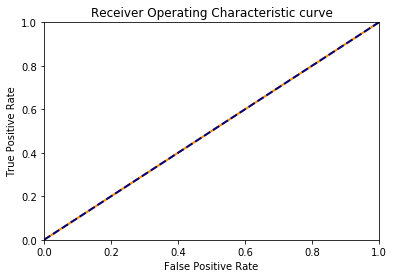

Confusion matrix:
[[1875    0]
 [1875    0]]

Accuracy: 0.5000

Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1875
           1       0.00      0.00      0.00      1875

   micro avg       0.50      0.50      0.50      3750
   macro avg       0.25      0.50      0.33      3750
weighted avg       0.25      0.50      0.33      3750

None
------------------------------------------------------------------------
Loading final model from file model5.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for model5.h5
235/235 [==============================] - 21s 90ms/step
ROC curve:


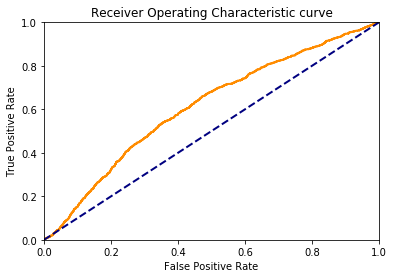

Confusion matrix:
[[1686  189]
 [1585  290]]

Accuracy: 0.5269

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.90      0.66      1875
           1       0.61      0.15      0.25      1875

   micro avg       0.53      0.53      0.53      3750
   macro avg       0.56      0.53      0.45      3750
weighted avg       0.56      0.53      0.45      3750

None
------------------------------------------------------------------------
Loading final model from file model6.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for model6.h5
235/235 [==============================] - 45s 191ms/step
ROC curve:


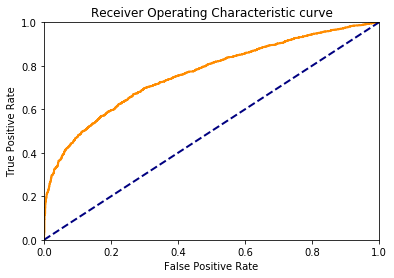

Confusion matrix:
[[1572  303]
 [ 834 1041]]

Accuracy: 0.6968

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      1875
           1       0.77      0.56      0.65      1875

   micro avg       0.70      0.70      0.70      3750
   macro avg       0.71      0.70      0.69      3750
weighted avg       0.71      0.70      0.69      3750

None
------------------------------------------------------------------------


In [32]:
#Load last train model for every method and check accuracy results
models = ['model1.h5','model2.h5','model3.h5','model4.h5','model5.h5','model6.h5',]
for m in models:
    print('Loading final model from file '+m)
    loadedmodel = load_model(m)
    print('Model already loaded')
    if(m=='model2.h5'):
        predict = valid_generator.flow_from_dataframe(
            dataframe = df_val,
            directory = dest_dir,
            has_ext = False,
            x_col = 'image', 
            y_col = 'level', 
            target_size = (IMAGE_SIZE, IMAGE_SIZE), 
            classes = [0, 1], 
            class_mode = 'binary', 
            batch_size = BATCH_SIZE, 
            shuffle = False, 
            color_mode = 'grayscale'
        )
    else:
        predict = valid_generator.flow_from_dataframe(
            dataframe = df_val,
            directory = dest_dir,
            has_ext = False,
            x_col = 'image', 
            y_col = 'level', 
            target_size = (IMAGE_SIZE, IMAGE_SIZE), 
            classes = [0, 1], 
            class_mode = 'binary', 
            batch_size = BATCH_SIZE, 
            shuffle = False
        )
    print('Display result for '+m)
    print(display_results(loadedmodel,predict))
    print('------------------------------------------------------------------------')
    del loadedmodel
    K.clear_session()

### 6.2. Scores for Best Model for Each Method
Next, we load each best model of each method we saved and apply display_result function.

Again, the result of each model will be discussed again in the Results and Discussion section.

Loading final model from file best_model1.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for best_model1.h5
235/235 [==============================] - 7s 32ms/step
ROC curve:


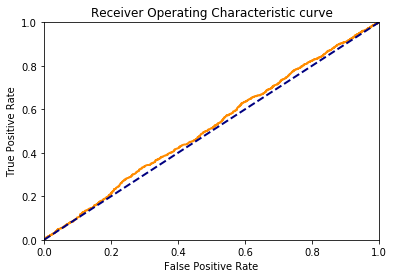

Confusion matrix:
[[ 371 1504]
 [ 328 1547]]

Accuracy: 0.5115

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.20      0.29      1875
           1       0.51      0.83      0.63      1875

   micro avg       0.51      0.51      0.51      3750
   macro avg       0.52      0.51      0.46      3750
weighted avg       0.52      0.51      0.46      3750

None
------------------------------------------------------------------------
Loading final model from file best_model2.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for best_model2.h5
235/235 [==============================] - 7s 29ms/step
ROC curve:


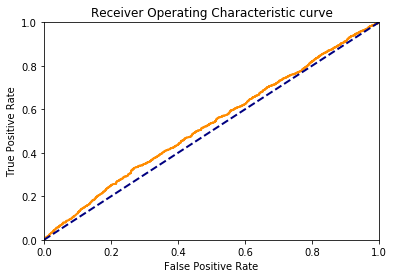

Confusion matrix:
[[   2 1873]
 [   2 1873]]

Accuracy: 0.5000

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      1875
           1       0.50      1.00      0.67      1875

   micro avg       0.50      0.50      0.50      3750
   macro avg       0.50      0.50      0.33      3750
weighted avg       0.50      0.50      0.33      3750

None
------------------------------------------------------------------------
Loading final model from file best_model3.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for best_model3.h5
235/235 [==============================] - 32s 136ms/step
ROC curve:


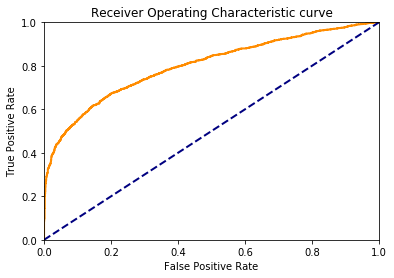

Confusion matrix:
[[1447  428]
 [ 582 1293]]

Accuracy: 0.7307

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1875
           1       0.75      0.69      0.72      1875

   micro avg       0.73      0.73      0.73      3750
   macro avg       0.73      0.73      0.73      3750
weighted avg       0.73      0.73      0.73      3750

None
------------------------------------------------------------------------
Loading final model from file best_model4.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for best_model4.h5
235/235 [==============================] - 33s 142ms/step
ROC curve:


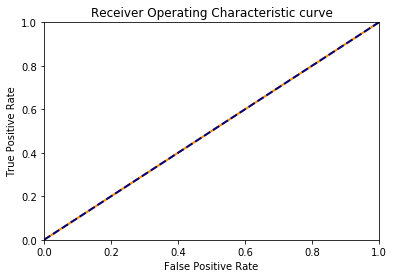

Confusion matrix:
[[1875    0]
 [1875    0]]

Accuracy: 0.5000

Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1875
           1       0.00      0.00      0.00      1875

   micro avg       0.50      0.50      0.50      3750
   macro avg       0.25      0.50      0.33      3750
weighted avg       0.25      0.50      0.33      3750

None
------------------------------------------------------------------------
Loading final model from file best_model5.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for best_model5.h5
235/235 [==============================] - 21s 88ms/step
ROC curve:


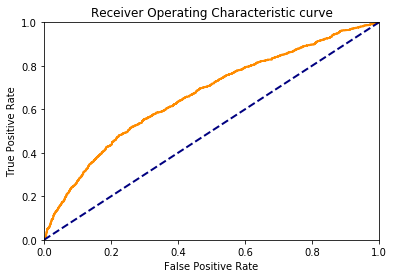

Confusion matrix:
[[1208  667]
 [ 763 1112]]

Accuracy: 0.6187

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.63      1875
           1       0.63      0.59      0.61      1875

   micro avg       0.62      0.62      0.62      3750
   macro avg       0.62      0.62      0.62      3750
weighted avg       0.62      0.62      0.62      3750

None
------------------------------------------------------------------------
Loading final model from file best_model6.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for best_model6.h5
235/235 [==============================] - 44s 189ms/step
ROC curve:


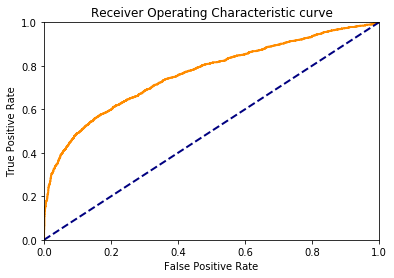

Confusion matrix:
[[1419  456]
 [ 677 1198]]

Accuracy: 0.6979

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.76      0.71      1875
           1       0.72      0.64      0.68      1875

   micro avg       0.70      0.70      0.70      3750
   macro avg       0.70      0.70      0.70      3750
weighted avg       0.70      0.70      0.70      3750

None
------------------------------------------------------------------------


In [33]:
#Load best train model for every method and check accuracy results
models = ['best_model1.h5','best_model2.h5','best_model3.h5','best_model4.h5','best_model5.h5','best_model6.h5',]
for m in models:
    print('Loading final model from file '+m)
    loadedmodel = load_model(m)
    print('Model already loaded')
    if(m=='best_model2.h5'):
        predict = valid_generator.flow_from_dataframe(
            dataframe = df_val,
            directory = dest_dir,
            has_ext = False,
            x_col = 'image', 
            y_col = 'level', 
            target_size = (IMAGE_SIZE, IMAGE_SIZE), 
            classes = [0, 1], 
            class_mode = 'binary', 
            batch_size = BATCH_SIZE, 
            shuffle = False, 
            color_mode = 'grayscale'
        )
    else:
        predict = valid_generator.flow_from_dataframe(
            dataframe = df_val,
            directory = dest_dir,
            has_ext = False,
            x_col = 'image', 
            y_col = 'level', 
            target_size = (IMAGE_SIZE, IMAGE_SIZE), 
            classes = [0, 1], 
            class_mode = 'binary', 
            batch_size = BATCH_SIZE, 
            shuffle = False
        )
    print('Display result for '+m)
    print(display_results(loadedmodel,predict))
    print('------------------------------------------------------------------------')
    del loadedmodel
    K.clear_session()

### 6.3. Test Scores for the Selected Method
As you can see, the most accurate model we have is absolutely the best model from method 3 - Xception Pre-trained Model with Color-image Dataset.

Compared to other models, this model has the highest accuracy score and f1-score. So, we choose this model as our model to test with unseen data from testing set.

Again, we will find matrix scores like a confusion matrix, model accuracy, precision, recall, f1-score, and support for this model using test dataset. Here are our code.

Loading final model from file best_model3.h5
Model already loaded
Found 3750 images belonging to 2 classes.
Display result for best_model3.h5
235/235 [==============================] - 39s 168ms/step
ROC curve:


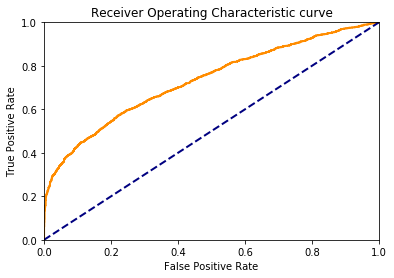

Confusion matrix:
[[1351  524]
 [ 723 1152]]

Accuracy: 0.6675

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1875
           1       0.69      0.61      0.65      1875

   micro avg       0.67      0.67      0.67      3750
   macro avg       0.67      0.67      0.67      3750
weighted avg       0.67      0.67      0.67      3750

None
------------------------------------------------------------------------


In [34]:
#Validate with test set
m = 'best_model3.h5'
print('Loading final model from file '+m)
loadedmodel = load_model(m)
print('Model already loaded')
predict = test_generator.flow_from_dataframe(
    dataframe = df_solution,
    directory = './input/300_test/',
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False
)
print('Display result for '+m)
print(display_results(loadedmodel,predict))
print('------------------------------------------------------------------------')
del loadedmodel
K.clear_session()

<b>In the last step, we come up with the model for diabetic retinopathy analysis with an estimated accuracy of 66.75%.</b>

## 7. Results and Discussion

In this case study, we performed 6 experiments with different model architectures to see which model performs the best for analyzing diabetic retinopathy disease. We compiled our model and tested it with the same balanced dataset (except model 2) to see how each model performs. To determine the best model, we chose validation loss and validation accuracy as the main criterias.

Before we compiled and trained models, we had performed image augmentation to our dataset first. Here is the setting for image augmentation that we experienced and found out to be the best setting.
- Rescale image value from 0-255 tp 0-1 (normalization)
- Allow zoom range at 0.1
- Prohibit featurewise center
- Prohibit samplewise center
- Prohibit featurewise standard normalization
- Prohibit samplewise standard normalization
- Prohibit whitening
- Allow rotation range at 360 degrees,
- Allow width shift range at 0.2
- Allow height shift range at 0.2
- Allow horizontal flip
- Allow vertical flip

Then, we used this image data to train our models, we chose 6 methods to try in this case study. Here are the methods we used.
- 4-layers Convolution Model with Color-image Dataset
- 4-layers Convolution Model with Gray-scale Image Dataset
- Xception Pre-trained Model with Color-image Dataset
- VGG16 Pre-trained Model with Color-image Dataset
- InceptionV3 Model Pre-trained Model with Color-image Dataset
- InceptionResNetV2 Pre-trained Model with Color-image Dataset

Next, we complied and validated our models. Here are the graphs showing how well each model performs.

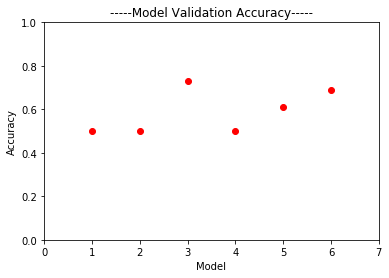

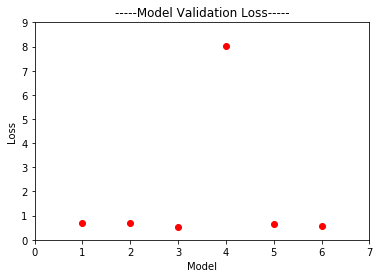

In [36]:
#Plot validtion accuracy for each model
plt.title('-----Model Validation Accuracy-----')
plt.plot([1,2,3,4,5,6], [0.50,0.50,0.73,0.50,0.61,0.69], 'ro')
plt.axis([0, 7, 0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

#Plot validtion loss for each model
plt.title('-----Model Validation Loss-----')
plt.plot([1,2,3,4,5,6], [0.69,0.69,0.55,8.04,0.65,0.56], 'ro')
plt.axis([0, 7, 0, 9])
plt.ylabel('Loss')
plt.xlabel('Model')
plt.show()

<b>The discussion for each method</b>

- At first, we used our own 4-layers convolution neural network with 2 dense layers and dropout for 0.5. The result of this model is absolutely underfitting that the model barely detects label-1 record. You can see that the accuracy is 51 % and the confusion matrix stated that it can only detect label-1 records for around 300 records from the total of 1875 records. We think that it is because of dropout layer in the model that creates underfitting and causes this model to lose its value.

- In the second method, we used the same model as method 1 but with the gray-scale version of image data. We assume in the beginning that gray-scale dataset will help our model improve accuracy and perofrmance. But after we compiled, trained and validated this model, we found out that gray-scale data did not help improve the model in any aspects. The result is still underfitting but this time it cannot detect label-0 record instead. (detected 2 records from 1875 records) The accuracy of this model is 50 %.

So, next, we did experiments with 4 pretrained models from keras applications, including Xception, VGG16, InceptionV3, and InceptionResNetV2.

- For Xception model, the estimated accuracy output from validation is 73%. This is the most accurate model we have. This model also gives the highest f1-score and produced least flase positive and true negation value in confusion matrix.

- For VGG16, it is the same as convolution model 1, the underfitting model. The accuracy is 50 % and the confusion matrix stated that it cannot detect label-1 record at all.

- For InceptionV3, it gives an accuracy around 61% and a validation loss around 65%

- For InceptionResNetV2, it gives an accuracy around 69% and a validation loss around 56%

You can see that Xception model is the most accurate model and has the smallest validation loss. So, we chose this model to perform the final validation with the testing image dataset.

<b>Here is the result from validating the chosen model with testing dataset</b>

Found 3750 images belonging to 2 classes.
235/235 [==============================] - 35s 150ms/step
ROC curve:


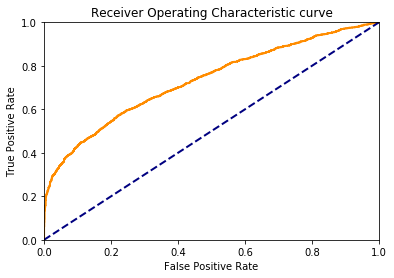

Confusion matrix:
[[1351  524]
 [ 723 1152]]

Accuracy: 0.6675

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1875
           1       0.69      0.61      0.65      1875

   micro avg       0.67      0.67      0.67      3750
   macro avg       0.67      0.67      0.67      3750
weighted avg       0.67      0.67      0.67      3750

None


In [36]:
#Validate with test set
m = 'best_model3.h5'
loadedmodel = load_model(m)
predict = test_generator.flow_from_dataframe(
    dataframe = df_solution,
    directory = './input/300_test/',
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False
)
print(display_results(loadedmodel,predict))
del loadedmodel
K.clear_session()

You can see that in the final step, we came up with the model for diabetic retinopathy analysis with an accuracy around 66.75%. Xception is by far the best model we experiment in this case study. It produced only 1247 mistakes guesses from total 3750 records as shown in the confusion matrix.

## 8. Conclusions

After guessing and trying many times with different methods and models, we have so many models at our hands that can predict the diabetic retinopathy. Each model we have trained has its own strength and weakness, some models may be underfitting due to the dataset and architecture settings, some models have a high accuracy but also a high validation loss. So, in this case study, we chose to focus on a validation accuracy value and a validation loss value to determine the best model suited for diabetic retinopathy analysis.

Throughout experiments, we learned that increasing data size definitely improves the accuracy of the model. We changed from data that instructors provided on GitHub to the dataset from Kaggle competition. Some models absolutely gives higher accuracy score compared to smaller dataset used. However, our belief that gray-scale dataset is better than color-image dataset was wrong. Changing dataset to gray-scale image version improves neither accuracy nor validation loss.

We found out that using an Xception pretrained model has produced the best performance in validation accuracy score and validation loss score when we tested with the validation dataset. However, when we calculated an accuracy again with the test set, we saw that the real accuracy value is a little lower than an accuracy from the validation set. Therefore, this means our model can predict diabetic retinopathy correctly around 65 times from the total of 100 times, or 65%. 

We believe that with more time and computation resources, we can make our model performed better by increasing the size of training data and solve the underfitting problem.

<hr>